In [8]:
from __future__ import print_function
import torch
from torchvision import datasets, transforms
import torchgeometry as tgm
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [9]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def imshow(imgs, label=''):
    imgs = vutils.make_grid(imgs, normalize=True)
    fig, ax = plt.subplots(1, squeeze=False, frameon=False, dpi=300)
    ax[0][0].imshow(np.transpose(imgs.cpu().detach().numpy(), (1, 2, 0)), interpolation='nearest')
    ax[0][0].axis('off')
    ax[0][0].set_title(label)
    fig.show()

def check_mem():
    return torch.cuda.memory_allocated()/1024/1024/1024

In [10]:
class PatchMaker:
    def __init__(self, mean, std, cuda=True):
        self.device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
        mean = torch.tensor(mean, dtype=torch.float)
        std = torch.tensor(std, dtype=torch.float)

        val = lambda x: ((x - mean) / std).to(self.device).unsqueeze(1).unsqueeze(1)
        self.min_val, self.max_val = val(0), val(1)
        
        to_pil = transforms.Compose([
            transforms.Normalize(np.zeros(3), 1/std),
            transforms.Normalize(-mean, np.ones(3)),
            transforms.Lambda(lambda img: torch.clamp(img, 0, 1)),
            transforms.ToPILImage()
        ])
        
        self.pil_patch = lambda : to_pil(self.patch.data.squeeze().detach().cpu())
    
    def net_init(self, model):
        self.net = model.to(self.device)
        self.net.eval()
        
        for param in self.net.parameters():
            param.requires_grad = False
        
    def patch_init(self, init_patch=None, epsilon=None, size=None, mask=None):
        assert init_patch is not None or size is not None
        self.epsilon = epsilon
        if init_patch is None:
            init_patch = torch.rand([3, size, size], device=self.device) * (self.max_val-self.min_val) + self.min_val
        self.patch = init_patch.unsqueeze(0).to(self.device)
        self.patch_size = self.patch.shape[-2:]
        if mask is None:
            mask = torch.tensor(create_circular_mask(*self.patch_size))
        self.mask = mask.to(torch.float).to(self.device)
        self.mask = self.mask.expand(1,1,-1,-1)
        dsize = self.patch_size
        if size is not None:
            scale = size / min(self.patch_size)
            dsize = (np.array(self.patch_size) * scale).astype(int)
            self.patch = self._transform(self.patch, 0, scale, dsize=dsize)
            self.mask  = self._transform(self.mask, 0, scale, dsize=dsize)
            self.mask  = (self.mask != 0).to(torch.float)
        self.patch = self.patch * self.mask + (1 - self.mask) * self.max_val.expand(3,*dsize)
        self.patch = torch.nn.Parameter(self.patch, requires_grad=True)
        self.patch_size = torch.tensor(self.patch.shape[-2:], device=self.device)
        
    def _transform(self, img, angle, scale, shear=None, location=None, dsize=None):
        if img.dim() < 4:
            img = img.unsqueeze(0)
        b = img.shape[0]
        angle = torch.zeros(b, device=self.device) + angle
        scale = torch.zeros(b, device=self.device) + scale
        center = torch.zeros(b, 2, device=self.device)
        center[..., 0] = img.shape[3] / 2 # x
        center[..., 1] = img.shape[2] / 2 # y

        M = tgm.get_rotation_matrix2d(center, angle, scale)
        if location is None:
            location = torch.zeros(2, device=self.device)
        location = (scale - 1).unsqueeze(1) * center + location
        M.T[2] += location.T
        if shear is None:
            shear = torch.zeros(2, device=self.device)
        sm = torch.zeros(b, 2, 3, device=self.device)
        sm[..., 0, 1] = shear[..., 0]
        sm[..., 1, 0] = shear[..., 1]
        M += sm
        if dsize is None:
            dsize = img.shape[-2:]
        return tgm.warp_affine(img, M, dsize)

    def clamp(self, image_tensor):
        return torch.max(torch.min(image_tensor, self.max_val), self.min_val)
            
    def _applicate_patch(self, image, location, rotation, scale, shear):
        bs = image.shape[0]
        mask  = self._transform(self.mask.expand(bs,-1,-1,-1),  rotation, scale, shear, location, image.shape[-2:])
        mask  = (mask != 0).to(torch.float)
        patch = self.clamp(self.patch)
        patch = self._transform(patch.expand(bs,-1,-1,-1), rotation, scale, shear, location, image.shape[-2:])
        
        applied = image * (1 - mask) + patch * mask
        return self.clamp(applied)
    
    def set_transforms(self, rotate_angle=(-90, 90), shear=(0, 0), size_by_im=(0.2, 0.45)):
        gen_rand             = lambda k,a,b: torch.rand(k, device=self.device) * (b-a) + a
        self.tr_rotate_angle = lambda k: gen_rand(k, *rotate_angle)
        self.tr_shear        = lambda k: gen_rand(k, *shear).unsqueeze(1).expand(-1,2)
        self.tr_size_by_im   = lambda k: gen_rand(k, *size_by_im)
    
    def _random_patch_placement(self, image):
        b = image.shape[0]
        rotation   = self.tr_rotate_angle(b)
        shear      = self.tr_shear(b)
        size_by_im = self.tr_size_by_im(b)

        im_size = torch.tensor(image.shape[-2:], device=self.device)

        side_size = min(im_size) * (size_by_im*2/np.pi).sqrt()

        scale = side_size / min(self.patch_size)
        
        location = torch.rand(b, 2, device=self.device) * (im_size - scale.unsqueeze(1) * self.patch_size.unsqueeze(0))
        
        return self._applicate_patch(image, location, rotation, scale, shear)

    def epoch(self, dataloader, target, optimizer=None, train=True):
        assert optimizer is not None or not train
        torch.set_grad_enabled(train)
        top1 = 0
        top5 = 0
        running_loss = 0.0
        pbar = tqdm(dataloader, desc='Starting...', leave=False)
        for data, labels in pbar:
            # pbar.write(str(check_mem()))
            data = data.to(self.device)
            labels = labels.to(self.device)

            if train:
                optimizer.zero_grad()
                self.net.zero_grad()

            x = self._random_patch_placement(data)

            adv_out = self.net(x)
            _, preds = adv_out.topk(5)

            criterion = torch.nn.CrossEntropyLoss()
            loss = criterion(adv_out, torch.tensor(data.size(0) * [target], device=self.device))

            if train:
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * data.size(0)
            
            for img_preds in preds:
                if target in img_preds:
                    top5 += 1
                    if target in img_preds[0]:
                        top1 +=1

            pbar.set_description(f'top1 - {top1}, top5 - {top5} of {(pbar.n+1) * data.size(0)}')

        pbar.close()
        return running_loss, top1, top5

In [11]:
# imagenet
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

img_size = 400

mean, std = np.array(mean, dtype=float), np.array(std, dtype=float)

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

tr = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0), ratio=(1., 1.)),
    to_tensor
])

inv_norm = transforms.Compose([
    transforms.Normalize(np.zeros(3), 1/std),
    transforms.Normalize(-mean, np.ones(3))
])

to_pil = transforms.Compose([
    inv_norm,
    transforms.Lambda(lambda img: torch.clamp(img, 0, 1)),
    transforms.ToPILImage()
])

sampler = torch.utils.data.RandomSampler

trainset = datasets.ImageNet(root='../data', split='train', transform=tr)
testset = datasets.ImageNet(root='../data', split='val', transform=tr)

def subset(imageset, size):
    res, _ = torch.utils.data.random_split(imageset, [size, len(imageset) - size])
    return res

def dataloader(imageset, batch_size):
    return torch.utils.data.DataLoader(imageset, batch_size=batch_size, shuffle=True)

In [12]:
from torchvision import models

ensemble = {
    'ResNet101'    : models.resnet101(pretrained=True),
    'VGG16'        : models.vgg16(pretrained=True),
    'VGG19 with bn'     : models.vgg19_bn(pretrained=True),
    'GoogLeNet'    : models.googlenet(pretrained=True),
    'Inception v3': models.inception_v3(pretrained=True)
}
ensemble = list(ensemble.items())

In [6]:
pm = PatchMaker(mean, std)
patch_size = 140
batch_size = 10

train_size = 50 * batch_size
test_size  = 50 * batch_size
n_epochs = 30
patch = to_tensor(Image.open('./owl.png'))

lr = 1
lr_change = { 10: 0.1, 20: 0.1 }
momentum = 0.9

pm.patch_init(patch, size=patch_size)
pm.set_transforms(rotate_angle=(-180, 180), shear=(0, 0.1), size_by_im=(0.1, 0.3))
def train_patch(target, n_epochs=n_epochs, lr=lr, train_size=train_size, momentum=momentum, batch_size=batch_size, patchname=None, savedir=None):
    patchname = patchname or 'patch'
    scores = [{ 'train': [], 'test': [] } for i in range(3)]

    epbar = tqdm(range(n_epochs), leave=True)
    for epoch in epbar:
        if epoch in lr_change:
            lr *= lr_change[epoch]
        np.random.shuffle(ensemble)
        epbar.set_description(f'Epoch {epoch+1}, lr={lr:.2f}')

        pbar = tqdm(ensemble, leave=False)
        t_sc = [0.0 for i in range(3)]
        for modelname, model in pbar:
            pbar.set_description(f'training {modelname}')
            pm.net_init(model)
            optimizer = torch.optim.SGD([pm.patch], lr=lr, momentum=momentum)
            dl = dataloader(subset(trainset, train_size), batch_size)
            res_sc = pm.epoch(dl, target, optimizer)
            t_sc = [res_sc[i] + t_sc[i] for i in range(3)]
        for i in range(3):
            scores[i]['train'].append(t_sc[i] / (train_size * len(ensemble)))
        pbar.close()

        pbar = tqdm(ensemble, leave=False)
        t_sc = [0.0 for i in range(3)]
        for modelname, model in pbar:
            pbar.set_description(f'testing {modelname}')
            pm.net_init(model)
            dl = dataloader(subset(testset, test_size), batch_size)
            res_sc = pm.epoch(dl, target, train=False)
            t_sc = [res_sc[i] + t_sc[i] for i in range(3)]
        for i in range(3):
            scores[i]['test'].append(t_sc[i] / (test_size * len(ensemble)))
        if savedir is not None:
                pm.pil_patch().save(Path(savedir) / f'{patchname}_ep_{epoch}.png')
        pbar.close()
    epbar.close()
    return scores
        
        
losses, top1_acc, top5_acc = train_patch(999, patchname='toilet_paper', savedir='./Patches')

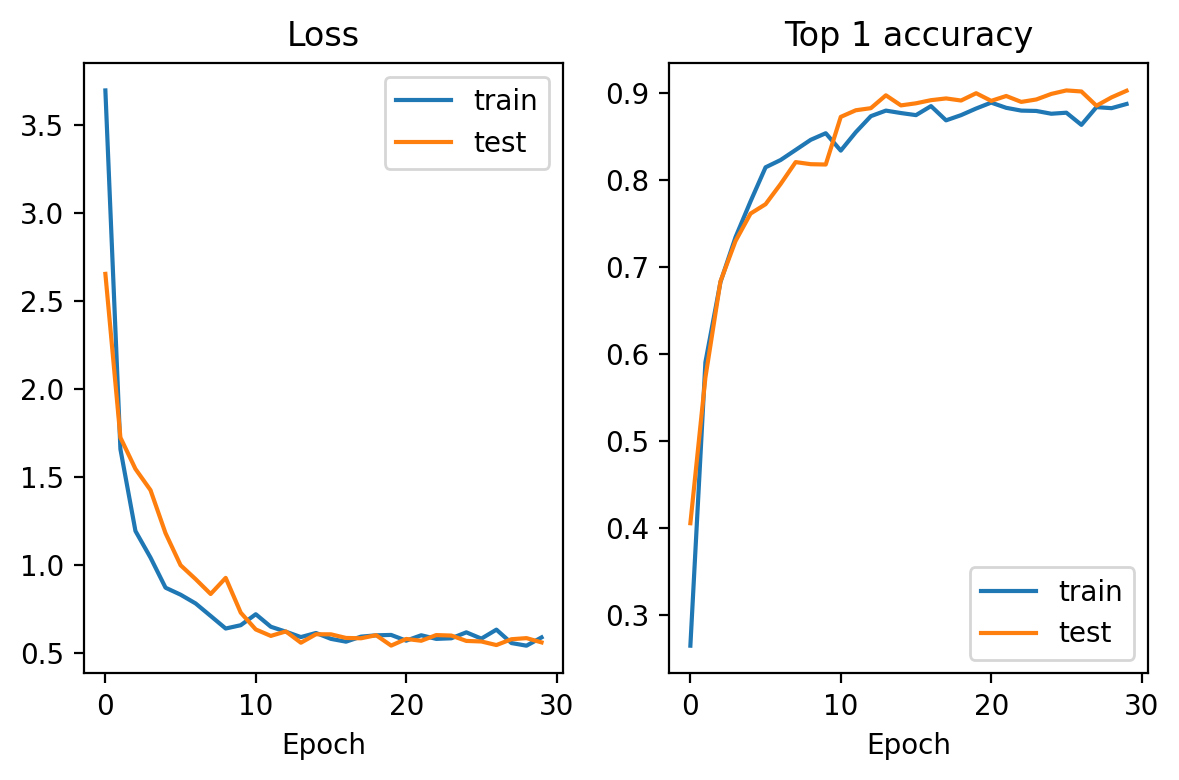

In [59]:
# patch = Image.open('./Patches/owlpatch_ep_59.png')
fig, ax = plt.subplots(1,2, squeeze=False, dpi=200)
for phase, ls in losses.items():
    ax[0][0].plot(ls, label=phase)
ax[0][0].legend()
ax[0][0].set_title('Loss')
ax[0][0].set_xlabel('Epoch')
# ax[1][0].axis('off')
# ax[1][0].imshow(patch)
for phase, ls in top1_acc.items():
    ax[0][1].plot(ls, label=phase)
ax[0][1].legend()
ax[0][1].set_title('Top 1 accuracy')
ax[0][1].set_xlabel('Epoch')
# for phase, ls in top5_acc.items():
#     ax[1][1].plot(ls, label=phase)
# ax[1][1].legend()
# ax[1][1].set_title('Top 5 accuracy')
# ax[1][1].set_xlabel('Epoch')
fig.tight_layout()

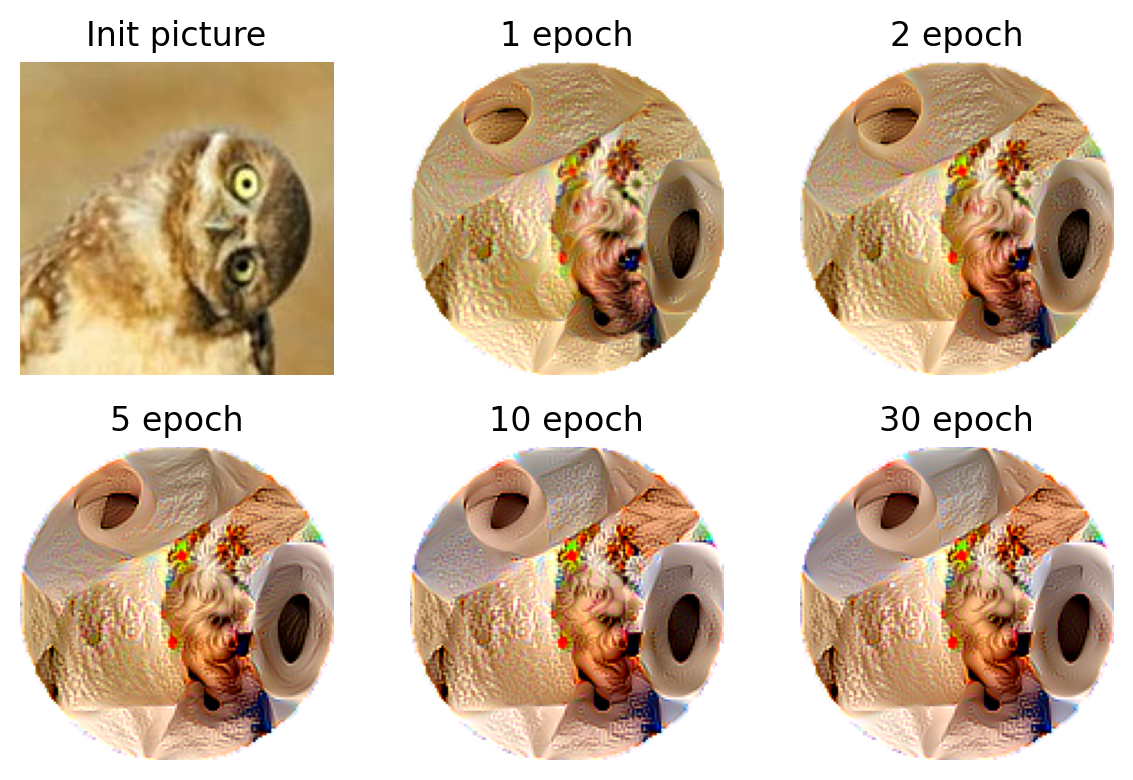

In [62]:
init = Image.open('./owl.png')
def owlpatch(i):
    return Image.open(f'./Patches/toilet_paper_ep_{i}.png')

fig, ax = plt.subplots(2,3, squeeze=False, dpi=200)
pis = [1, 1, 2, 5, 10, 30]
cur_i = 0
for a in ax:
    for x in a:
        x.axis('off')
        x.set_title(f'{pis[cur_i]} epoch')
        x.imshow(owlpatch(pis[cur_i]-1))
        cur_i += 1
        
ax[0,0].set_title('Init picture')
ax[0,0].imshow(init)

fig.tight_layout()

In [19]:
pm = PatchMaker(mean, std)
pm.patch_init(to_tensor(patch))
pm.set_transforms(rotate_angle=(-180, 180), shear=(0, 0.1), size_by_im=(0.1, 0.15))
netname, net = ensemble[4]
pm.net_init(net)

In [18]:
it = iter(dataloader(trainset, 1))

In [48]:
# image, gt = next(it)
with torch.no_grad():
    data = image.to(pm.device)
    out = pm.net(data)
    _, init_preds = out.topk(5)
    
    x = pm._random_patch_placement(data)

    adv_out = pm.net(x)
    _, preds = adv_out.topk(5)
    

In [50]:
trainset.classes[gt.item()][0]

'microphone'

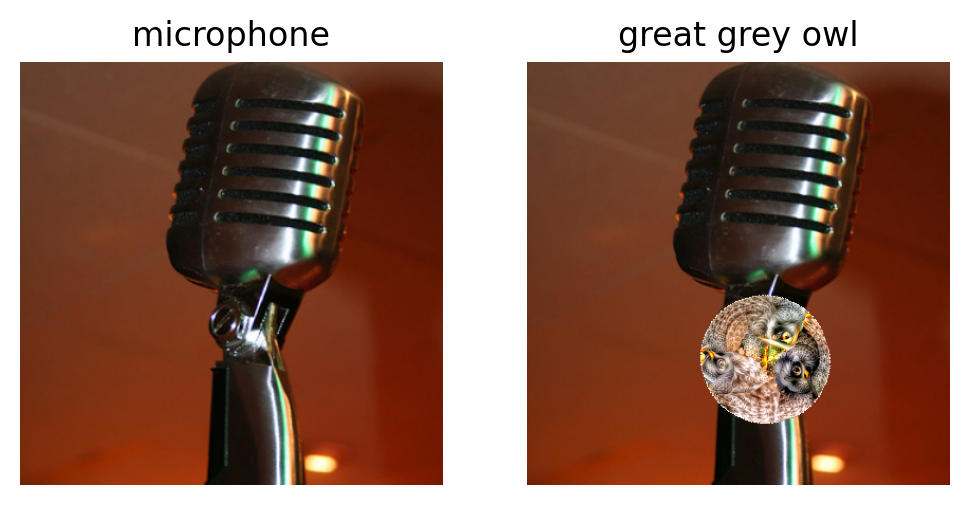

In [55]:
fig, ax = plt.subplots(1,2, squeeze=False, dpi=200)
ax[0,0].axis('off')
ax[0,0].set_title(trainset.classes[init_preds.squeeze()[0].item()][0])
ax[0,0].imshow(to_pil(data.cpu().detach().squeeze()))
ax[0,1].axis('off')
ax[0,1].set_title(trainset.classes[preds.squeeze()[0].item()][0])
ax[0,1].imshow(to_pil(x.cpu().detach().squeeze()))

In [20]:
imagenet.classes

[('tench', 'Tinca tinca'),
 ('goldfish', 'Carassius auratus'),
 ('great white shark',
  'white shark',
  'man-eater',
  'man-eating shark',
  'Carcharodon carcharias'),
 ('tiger shark', 'Galeocerdo cuvieri'),
 ('hammerhead', 'hammerhead shark'),
 ('electric ray', 'crampfish', 'numbfish', 'torpedo'),
 ('stingray',),
 ('cock',),
 ('hen',),
 ('ostrich', 'Struthio camelus'),
 ('brambling', 'Fringilla montifringilla'),
 ('goldfinch', 'Carduelis carduelis'),
 ('house finch', 'linnet', 'Carpodacus mexicanus'),
 ('junco', 'snowbird'),
 ('indigo bunting', 'indigo finch', 'indigo bird', 'Passerina cyanea'),
 ('robin', 'American robin', 'Turdus migratorius'),
 ('bulbul',),
 ('jay',),
 ('magpie',),
 ('chickadee',),
 ('water ouzel', 'dipper'),
 ('kite',),
 ('bald eagle', 'American eagle', 'Haliaeetus leucocephalus'),
 ('vulture',),
 ('great grey owl', 'great gray owl', 'Strix nebulosa'),
 ('European fire salamander', 'Salamandra salamandra'),
 ('common newt', 'Triturus vulgaris'),
 ('eft',),
 ('spo

In [19]:
trainset.class_to_idx['toilet paper']

999

In [ ]:
pm = None
testloader = None
trainloader = None
testset = None
trainset = None

In [2]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |